Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров.

In [41]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn import model_selection
import numpy as np
from tqdm import tqdm
import random

In [42]:
from sklearn.datasets import load_diabetes

In [43]:
X, y = load_diabetes(return_X_y=True)

In [44]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [45]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются 
    #с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [46]:
#В качестве функционала ошибки будем использовать среднеквадратичную ошибку
mean_squared_error = lambda y, z: np.mean((y - z)**2)


Используем 
L
2
 loss 
L
(
y
,
z
)
=
(
y
−
z
)
2
,
 ее производная по 
z
 примет вид 
L
′
(
y
,
z
)
=
2
(
z
−
y
)
. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [47]:
def bias(y, z):
    return (y - z)

In [48]:
def gb_fit(n_trees, max_depth, X, y, coefs, eta):
    trees = []
    
    for i in range(n_trees):
        target = np.zeros(shape=y.shape) if len(trees) == 0 else gb_predict(X, trees, coefs, eta)

        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        tree.fit(X, bias(y, target))
        trees.append(tree)
        
    return trees

Зададим начальные коэффициенты 
γ
=
1
, максимальная глубина деревьев 3, шаг градиентного бустинга 
η
=
0.1
. Будем менять число деревьев в ансамбле от 1 до 30.

In [49]:
max_depth = 3
eta = 0.1
n_trees_max = 30
n_trees_arr = [i+1 for i in range(n_trees_max)]

coefs = np.ones(n_trees_max)
trees = gb_fit(n_trees_max, max_depth, X_train, y_train, coefs, eta)

In [50]:
train_errors = []
test_errors = []

for n_trees in n_trees_arr:
    y_train_pred = gb_predict(X_train, trees[0:n_trees], coefs[0:n_trees], eta)
    y_test_pred = gb_predict(X_test, trees[0:n_trees], coefs[0:n_trees], eta)

    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

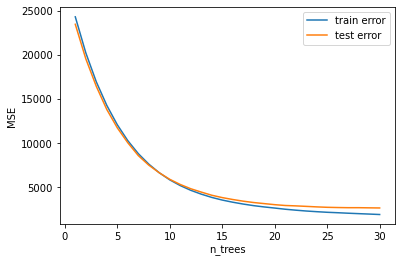

In [51]:
plt.plot(n_trees_arr, train_errors, label='train error')
plt.plot(n_trees_arr, test_errors, label='test error')
plt.xlabel('n_trees')
plt.ylabel('MSE')
plt.legend()
plt.show()

при увеличении числа деревьев точность модели увеличивается. Переобучение не наступает из-за маленького шага градиентного бустинга. Теперь зададим число деревьев равное 10. Будем менять глубину деревьев от 1 до 30.

In [39]:
n_trees = 10
eta = 0.1
coefs = np.ones(n_trees)

train_errors = []
test_errors = []

max_depth_arr = np.arange(1, 31, 1)

for max_depth in max_depth_arr:
    trees = gb_fit(n_trees, max_depth, X_train, y_train, coefs, eta)

    y_train_pred = gb_predict(X_train, trees, coefs, eta)
    y_test_pred = gb_predict(X_test, trees, coefs, eta)

    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

In [52]:
n_trees = 10
eta = 0.1
coefs = np.ones(n_trees)

train_errors = []
test_errors = []

max_depth_arr = np.arange(1, 31, 1)

for max_depth in max_depth_arr:
    trees = gb_fit(n_trees, max_depth, X_train, y_train, coefs, eta)

    y_train_pred = gb_predict(X_train, trees, coefs, eta)
    y_test_pred = gb_predict(X_test, trees, coefs, eta)

    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

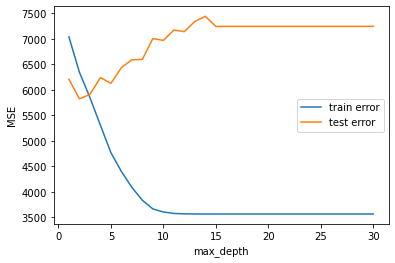

In [53]:
plt.plot(max_depth_arr, train_errors, label='train error')
plt.plot(max_depth_arr, test_errors, label='test error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend()
plt.show()

С увеличением глубины деревьев, точность на тренировочной выборке растёт, а на тестовой в какой-то момент начинает уменьшаться. Модель переобучается.

Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [54]:
def get_bootstrap(data, labels, alpha):
    n_samples = int(alpha * X.shape[0])
    sample_indexes = [random.randint(0, n_samples-1) for _ in range(n_samples)]
    
    return data[sample_indexes], labels[sample_indexes]   

In [55]:
def gb_fit_bootstarap(n_trees, max_depth, X, y, coefs, eta):
    trees = []    

    for i in range(n_trees):
        X_bootstrap, y_bootstrap = get_bootstrap(X, y, 0.5)
        target = np.zeros(shape=y_bootstrap.shape) if len(trees) == 0 else gb_predict(X_bootstrap, trees, coefs, eta)
        
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        tree.fit(X_bootstrap, bias(y_bootstrap, target))
        trees.append(tree)
        
    return trees
    

In [56]:
max_depth = 3
eta = 0.1
n_trees_max = 10
n_trees_arr = [i+1 for i in range(n_trees_max)]

coefs = np.ones(n_trees_max)

# деревья, построенные на тренировочной выборке без бутстрапирования выборки
trees = gb_fit(n_trees_max, max_depth, X_train, y_train, coefs, eta)

# деревья, построенные с применением бутстрапирования на тренировочной выборке
trees_b = gb_fit_bootstarap(n_trees_max, max_depth, X_train, y_train, coefs, eta) 

In [58]:
test_errors = []
train_errors = []
test_errors_b = []
train_errors_b = []

for n_trees in n_trees_arr:
    # градиентный бустинг
    y_test_pred = gb_predict(X_test, trees[0:n_trees], coefs[0:n_trees], eta)
    y_train_pred = gb_predict(X_train, trees[0:n_trees], coefs[0:n_trees], eta)

    test_errors.append(mean_squared_error(y_test, y_test_pred))
    train_errors.append(mean_squared_error(y_train, y_train_pred))

    # стохастический градиентный бустинг
    y_test_pred_b = gb_predict(X_test, trees_b[0:n_trees], coefs[0:n_trees], eta)
    y_train_pred_b = gb_predict(X_train, trees_b[0:n_trees], coefs[0:n_trees], eta)

    test_errors_b.append(mean_squared_error(y_test, y_test_pred_b))
    train_errors_b.append(mean_squared_error(y_train, y_train_pred_b))

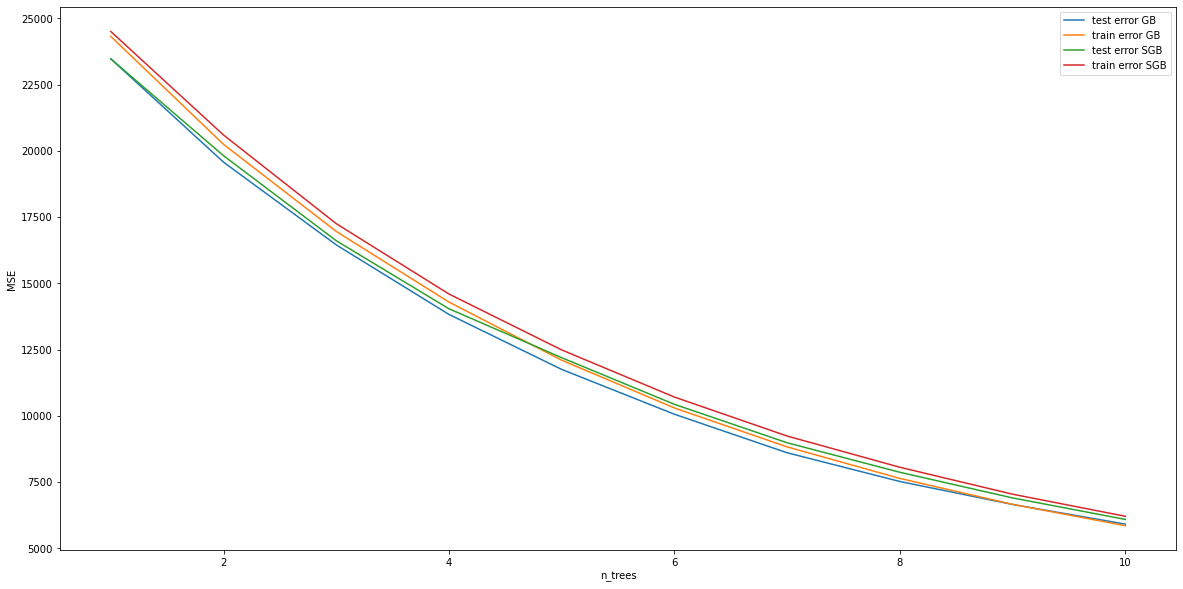

In [59]:
plt.figure(figsize=(20,10))
plt.plot(n_trees_arr, test_errors, label='test error GB')
plt.plot(n_trees_arr, train_errors, label='train error GB')
plt.plot(n_trees_arr, test_errors_b, label='test error SGB')
plt.plot(n_trees_arr, train_errors_b, label='train error SGB')
plt.xlabel('n_trees')
plt.ylabel('MSE')
plt.legend()
plt.show()

Результат примерно одинаковый. При большом количестве шагов результат у модели стохастического градиентного бустинга лучше.